# Regularized Linear Regression and Bias v.s. Variance

Stanford CS229 - Machine Learning by Andrew Ng. Programming exercise 5 with solutions.

Please check out [the repository on GitHub](https://github.com/rickwierenga/CS229-Python/). If you spot any mistakes or inconcistencies, please create an issue. For questions you can find me on Twitter: [@rickwierenga](https://twitter.com/rickwierenga). Starring the project on GitHub means a ton to me!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import minimize
%matplotlib inline

## Regularized Linear Regression

---
In the first half of the exercise, you will implement regularized linear regres- sion to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diag- nostics of debugging learning algorithms and examine the effects of bias v.s. variance.

Start by loading the data.

In [2]:
import scipy.io as sio

# Load data
data = sio.loadmat("ex5data1.mat")
X = data["X"]
m, n = X.shape
y = data["y"].reshape(m)
Xval = data['Xval']
mval, nval = Xval.shape
yval = data['yval'].reshape(mval)

# Add bias to X
X = np.hstack((np.ones((m, 1)), X))
Xval = np.hstack((np.ones((mval, 1)), Xval))

### Visualising the data

Text(0, 0.5, 'Water flowing out of the dam (y)')

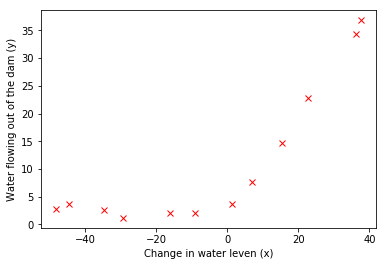

In [3]:
plt.plot(X[:, 1], y, 'rx')
plt.xlabel('Change in water leven (x)')
plt.ylabel('Water flowing out of the dam (y)')

Recall the cost function for regularized linear regression: 

$$J(\theta) = \frac{1}{m}(\displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2) + \frac{\lambda}{m}\displaystyle\sum_{j=1}^{n}{\theta_j}^2$$

**Exercise**: Write a regularized vectorized linear regression function.

In [4]:
def linear_reg_cost_function(theta, X, y, _lambda):
    m = len(y)
    cost = (1 / (2 * m)) * (X @ theta - y).T @ (X @ theta - y)
    regularization = (_lambda / (2 * m)) * np.sum(theta[1:] ** 2)
    return cost + regularization

According to the exercise, using ones for theta should return 303.993 as intial cost.

In [5]:
initial_theta = np.ones(2)
linear_reg_cost_function(initial_theta, X, y, _lambda=1)

303.9931922202643

### Regularized linear regression gradient

The partial derrivatives for $\theta_j$:

$$\frac{\delta J(\theta)}{\delta\theta_j} = \frac{1}{m}\displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_i^{(i)}$$ for $j=0$

$$\frac{\delta J(\theta)}{\delta\theta_j} = (\frac{1}{m}\displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_i^{(i)}) + \frac{\lambda}{m}\theta_j$$ for $j\geqslant 1$

Vectorized: 

$$\frac{\delta J(\theta)}{\delta\theta_j} = \frac{1}{m} \cdot X^T \cdot (X\theta - \vec{y}) $$

**Exercise**: Find the partial derrivatives of $J(\theta)$. Your code should not contain any loops.

In [6]:
def compute_gradient(theta, X, y, _lambda):
    hx = X @ theta
    cost = (1/m) * X.T @ (hx - y)
    regularization = (_lambda/m) * np.concatenate(([0], theta[1:]))
    return cost + regularization

You should get the following values: $\begin{bmatrix}-15.30 && 598.250 \end{bmatrix}$.

In [7]:
compute_gradient(initial_theta, X, y, _lambda=1)

array([-15.30301567, 598.25074417])

### Training the mdoel
Now we can train the model using `scipy.optimize.minimize`. In this implementation, we set $\lambda$ to 0.

In [8]:
_lambda = 0
args = (X, y, _lambda)
result = minimize(linear_reg_cost_function, initial_theta, args=args,
                  method='CG', jac=compute_gradient,
                  options={'maxiter': 50, 'disp': True})
theta = result.x
theta

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


array([13.08790734,  0.36777925])

### Visualize the found $\theta$

Althought the found value is not a good value, it's the best conjugate gradient could find using our model.

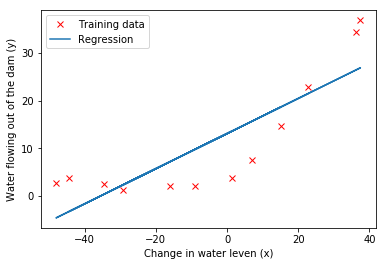

In [9]:
plt.plot(X[:,1], y, 'rx', label='Training data')
plt.plot(X[:,1], X.dot(theta), label='Regression')
plt.legend()
plt.xlabel('Change in water leven (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

## Bias Variance
Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

### Learning Curves
You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size.

This model has a high bias problem.

**Exercise**: Implement the learning curve function.

In [10]:
def learning_curve(X, y, Xval, yval, _lambda):
    """ Get the learning curves for each value of m
    
    Returns:
    :error_train: The training error of the dataset until i
    :error_val:   The error of the _entire_ cross validation set
    """
    m, n = X.shape
    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))
    
    for i in range(1, m+1):
        # Get a subset of the data
        X_ = X[:i]
        y_ = y[:i]

        # Get the trained theta and cost
        args = (X_, y_, _lambda)
        initial_theta = np.ones(n)
        result = minimize(linear_reg_cost_function, initial_theta, args=args,
                  method='CG', jac=compute_gradient,
                  options={'maxiter': 50, 'disp': False})
        error_train[i-1] = result.fun
        theta = result.x
        
        # Get the cost for the cross-validation set
        error_val[i-1] = linear_reg_cost_function(theta, Xval, yval, _lambda)
    
    return error_train, error_val

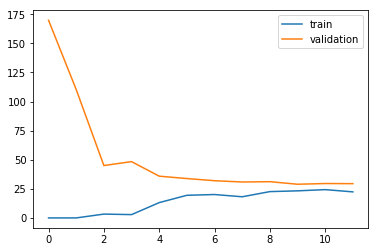

In [11]:
error_train, error_val = learning_curve(X, y, Xval, yval, _lambda)
plt.plot(error_train, label='train')
plt.plot(error_val, label='validation')
plt.legend()

## Polynomial Regression
The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features.

**Exercise**: Implement the function that maps the original training set X of size $m \times 1$ into its higher powers. Specifically, when a training set X of size m × 1 is passed into the function, the function should return a $m \times p$ matrix.

In [12]:
def polynomial_features(X, p):
    m = len(X)
    X_poly = X
    for i in range(2, p + 1):
        X_poly = np.hstack((X_poly, X ** i))
    return X_poly

Remember feature scaling:

$$X := \frac{X - \mu}{\sigma}$$

Where $\mu$ is the average value of $X$ and $\sigma$ is the standard deviation.

**Exercise**: Implement feature scaling.

In [13]:
def scale_features(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    return (X - mu) / sigma, mu, sigma

Add polynomial features to $X$ and normalize it.

In [14]:
p = 8

# X
X_poly = polynomial_features(X[:, 1:], p) # ignore the bias column when adding polynomial features.
X_poly, mu, sigma = scale_features(X_poly)
X_poly = np.hstack((np.ones((m, 1)), X_poly))

# X_val
X_val_poly = polynomial_features(X[:, 1:], p) # ignore the bias column when adding polynomial features.
X_val_poly = (X_val_poly - mu) / sigma
X_val_poly = np.hstack((np.ones((m, 1)), X_val_poly))

# X_test
X_test_poly = polynomial_features(X[:, 1:], p) # ignore the bias column when adding polynomial features.
X_test_poly = (X_test_poly - mu) / sigma
X_test_poly = np.hstack((np.ones((m, 1)), X_test_poly))

### Learning polynomial regression

This example shows the learning curve and fit without regularization (high variance)

In [15]:
_lambda = 0
args = (X_poly, y, _lambda)
initial_theta = np.ones(p+1)
result = minimize(linear_reg_cost_function, initial_theta, args=args,
                  method='CG', jac=compute_gradient,
                  options={'maxiter': 1000, 'disp': True})
theta = result.x

Optimization terminated successfully.
         Current function value: 0.028900
         Iterations: 786
         Function evaluations: 1507
         Gradient evaluations: 1507


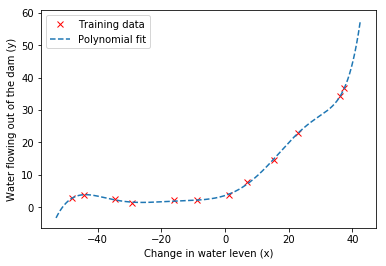

In [16]:
# Plot training data
plt.plot(X[:,1], y, 'rx', label='Training data')

# Plot polynomial fit
space = np.array(np.arange(np.min(X) - 5, np.max(X) + 5, 0.05)).reshape((1912, 1))
X_poly_plt = polynomial_features(space, p)
X_poly_plt = (X_poly_plt - mu) / sigma
X_poly_plt = np.hstack((np.ones((X_poly_plt.shape[0], 1)), X_poly_plt))
plt.plot(space, X_poly_plt @ theta, '--', label='Polynomial fit')

# Plot
plt.legend()
plt.xlabel('Change in water leven (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

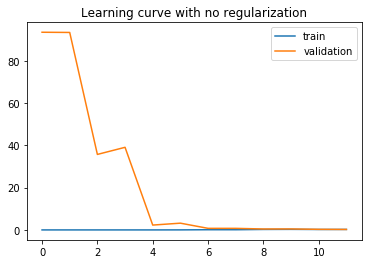

In [17]:
error_train, error_val = learning_curve(X_poly, y, X_val_poly, y, _lambda)
plt.plot(error_train, label='train')
plt.plot(error_val, label='validation')
plt.title('Learning curve with no regularization')
plt.legend()

### Adjusting the regularization parameter

In [18]:
def plot_regularization(_lambda):
    """ Plot the fit and learning curve for a regularization parameter _lambda """
    
    # 1. Fit
    
    # Find theta
    args = (X_poly, y, _lambda)
    initial_theta = np.ones(p+1)
    result = minimize(linear_reg_cost_function, initial_theta, args=args,
                      method='CG', jac=compute_gradient,
                      options={'maxiter': 1000, 'disp': False})
    theta = result.x
    
    # Plot training data
    plt.plot(X[:,1], y, 'rx', label='Training data')

    # Plot polynomial fit
    space = np.array(np.arange(np.min(X) - 5, np.max(X) + 5, 0.05)).reshape((1912, 1))
    X_poly_plt = polynomial_features(space, p)
    X_poly_plt = (X_poly_plt - mu) / sigma
    X_poly_plt = np.hstack((np.ones((X_poly_plt.shape[0], 1)), X_poly_plt))
    plt.plot(space, X_poly_plt @ theta, '--', label='Polynomial fit')

    # Plot
    plt.legend()
    plt.xlabel('Change in water leven (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.show()
    
    
    # 2. Learning curve
    
    # Plot learning curve
    error_train, error_val = learning_curve(X_poly, y, X_val_poly, y, _lambda)
    plt.plot(error_train, label='train')
    plt.plot(error_val, label='validation')
    plt.title('Learning curve with no regularization')
    plt.legend()
    
    plt.show()

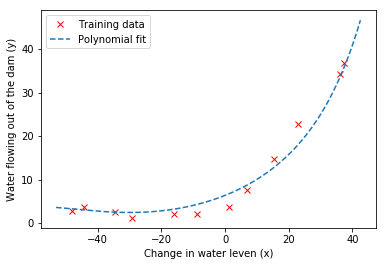

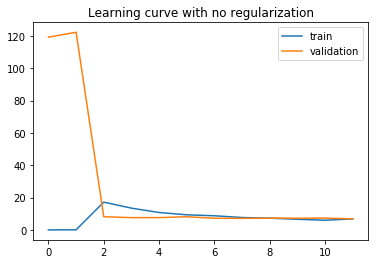

In [19]:
# Good regularization
plot_regularization(1)

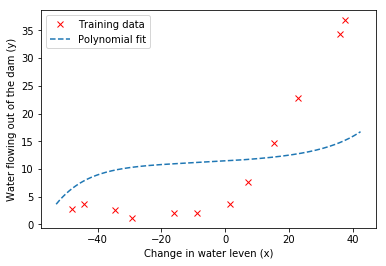

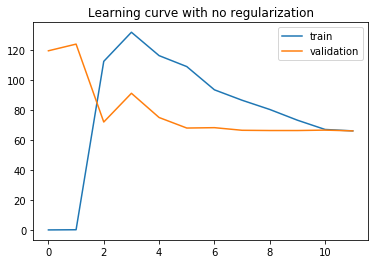

In [20]:
# (Way) too much regularization
plot_regularization(100)